# Respiratory Rate Estimation

Authors: Rossi Cecilia, Merotto Alberto, Canderle Filippo

Emails: cecilia.rossi.3@studenti.unipd.it , alberto.merotto@studenti.unipd.it , filippo.canderle@studenti.unipd.it

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is an another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the respiratory rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 

## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )

In [1]:
import numpy as np
import pandas as pd
import statistics as stats
import matplotlib.pyplot as plt
from scipy import optimize, fftpack
from matplotlib.colors import LogNorm
from scipy import signal
import os
from scipy.signal import find_peaks
import seaborn as sns

In [2]:
def load_txt(fname, start, end):
    
    params=['Log Freq',"AccX","AccY","AccZ","GyroX", "GyroY", "GyroZ"]
    df = pd.read_csv(fname, sep='\t', usecols = params)
    logFreq = df.loc[1,'Log Freq']
    df = df.iloc[start:end, :].reset_index()
    df = df[["AccX","AccY","AccZ","GyroX", "GyroY", "GyroZ"]]
    
    return df, logFreq

  1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.

In [3]:
def subplot_signals(df, logFreq, zoom):

    sampling_rate = 1/logFreq
    time = np.arange(0, len(df["AccX"]) * sampling_rate, sampling_rate)
    
    signal=[]
    mean_of_signal=[]
    stDev_of_signal=[]
    name=["AccX","AccY","AccZ","GyroX", "GyroY", "GyroZ"]
    for el in name: 
        signal.append(df[el])
        mean_of_signal.append(df[el].mean())
        stDev_of_signal.append(df[el].mean())
    
    fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))
    i=0
    for row in range(2):
        for col in range(3):
            axs[row, col].plot(time, signal[i])
            axs[row, col].set_title(name[i])
            axs[row, col].set_xlabel('Time (sec)')
            axs[row, col].set_ylabel('Accelleration (Rad/s)')
            i=i+1

    plt.tight_layout()
    plt.show()

1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  

In [4]:
def pca_eigenvalue_decomposition(X):
    
    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    
    covariance_matrix = np.cov(X.T)
    
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    eigenvalues_sorted_indices = np.argsort(-eigenvalues)
    eigenvalues = eigenvalues[eigenvalues_sorted_indices]
    eigenvectors = eigenvectors[:, eigenvalues_sorted_indices]
    
    explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
    
    return eigenvalues, eigenvectors, explained_variance_ratio

def scatter_pca(X_pca):
   
    plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha = 0.4)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.title("PCA Plot")
    plt.show()

def plot_princ_pca(X_pca,tipo,zoom):
    
    sampling_rate = 1/200
    time = np.arange(0, X_pca.shape[0] * sampling_rate, sampling_rate)
    fig, axes = plt.subplots(ncols = 2, nrows=1, figsize=(12,6))

    axes[0].plot(time, X_pca.T[0])
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Signal")
    axes[0].set_title('Principal Component')
    
    axes[1].plot(time, X_pca.T[1])
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Signal")
    axes[1].set_title('Second Principal Component')
    
    fig.tight_layout()
    plt.show()

2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.

In [5]:
def descriptive_statistics(data,stampa=False):
    mean = np.mean(data, axis=0)
    median = np.median(data, axis = 0)
    variance = np.var(data, axis = 0)
    standard_deviation = np.std(data, axis = 0)
    percentiles_col1 = np.percentile(data[:,0], [25, 75])
    percentiles_col2 = np.percentile(data[:,1], [25, 75])
    correlation_coefficient = np.corrcoef(data, rowvar=False)
    
    if stampa==True:
        print("Mean: \n", mean[0], mean[1])
        print("Mode: \n", stats.mode(data[:,0]), stats.mode(data[:,1]))
        print("Median: \n", median[0], median[1])
        print("Variance: \n", variance[0], variance[1])
        print("Standard Deviation: \n", standard_deviation[0], standard_deviation[1])
        print("25th Percentiles: \n", percentiles_col1[0], percentiles_col2[0])
        print("75th Percentiles: \n", percentiles_col1[1], percentiles_col2[1])
        print("Correlation Coefficient: \n", correlation_coefficient[0,1])
    
    return mean, median, variance, standard_deviation , (percentiles_col1, percentiles_col2), correlation_coefficient[0,1]

2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step.

In [6]:
def fft_transform(sig, logFreq):
    
    sig_fft = np.abs(fftpack.fft2(sig))
    sample_freq = fftpack.fftfreq(sig.shape[0], d=1/logFreq)
    freqs = sample_freq[np.where(sample_freq > 0)]
    sig_comp1_fft = sig_fft[:,0]
    sig_comp2_fft = sig_fft[:,1]

    peak_freq_comp1 = sample_freq[sig_comp1_fft.argmax()]
    peak_freq_comp2 = sample_freq[sig_comp2_fft.argmax()]
    
    return sig_comp1_fft, sig_comp2_fft, peak_freq_comp1, peak_freq_comp2, sample_freq

### Load, Preprocess and extract metrics from data

Then after defining the function that allow us to perform the first part of our work, related to loading data, preprocess them and extract some relevant in formation, let's call them supposing to use:
* `center_sternum.txt`
* `4_Chest_sweater.txt`


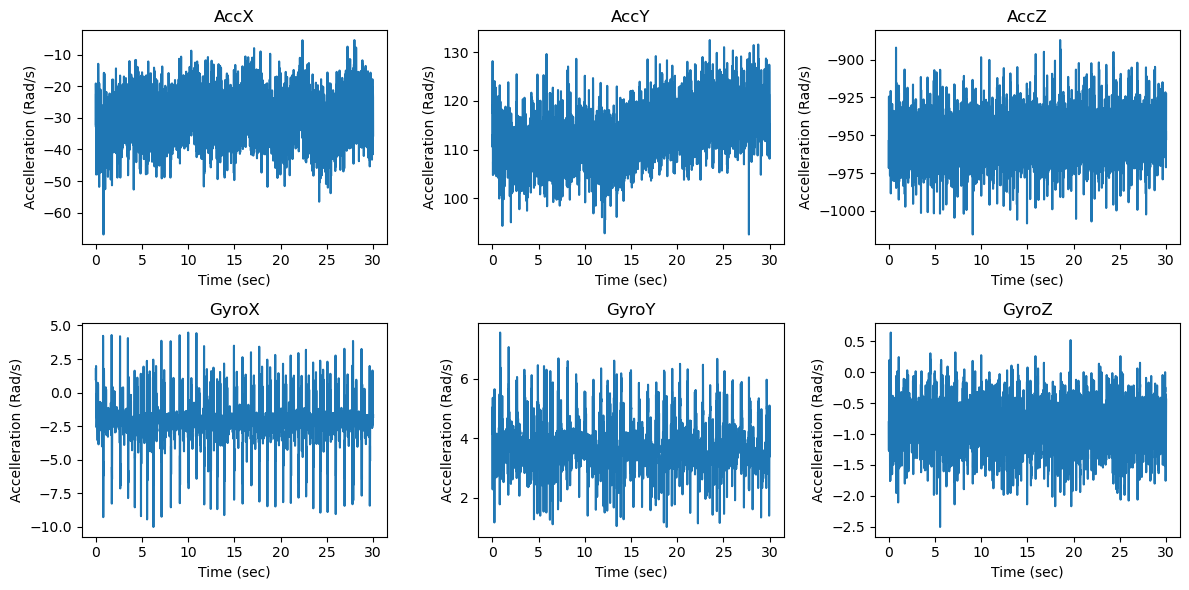

Variance of Accelleration mantained after PCA:  0.7932664648704659


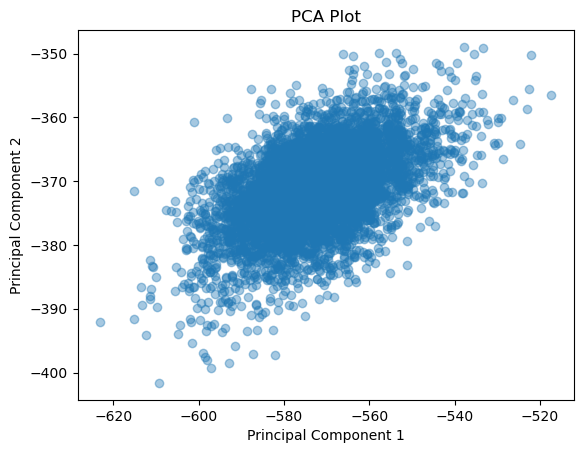

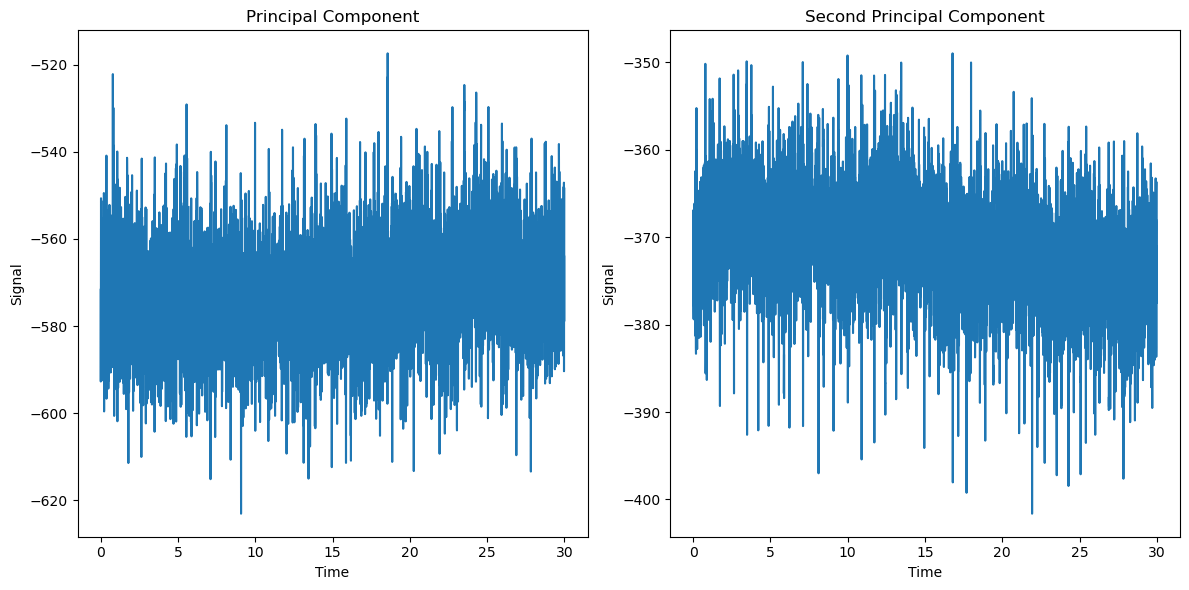

Variance of Angular Velocity mantained after PCA:  0.8135703846565681


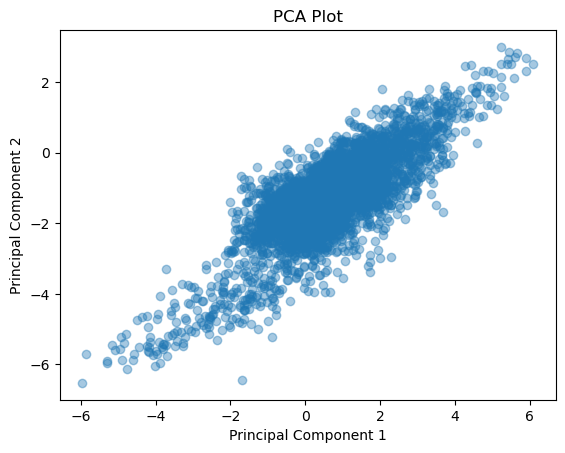

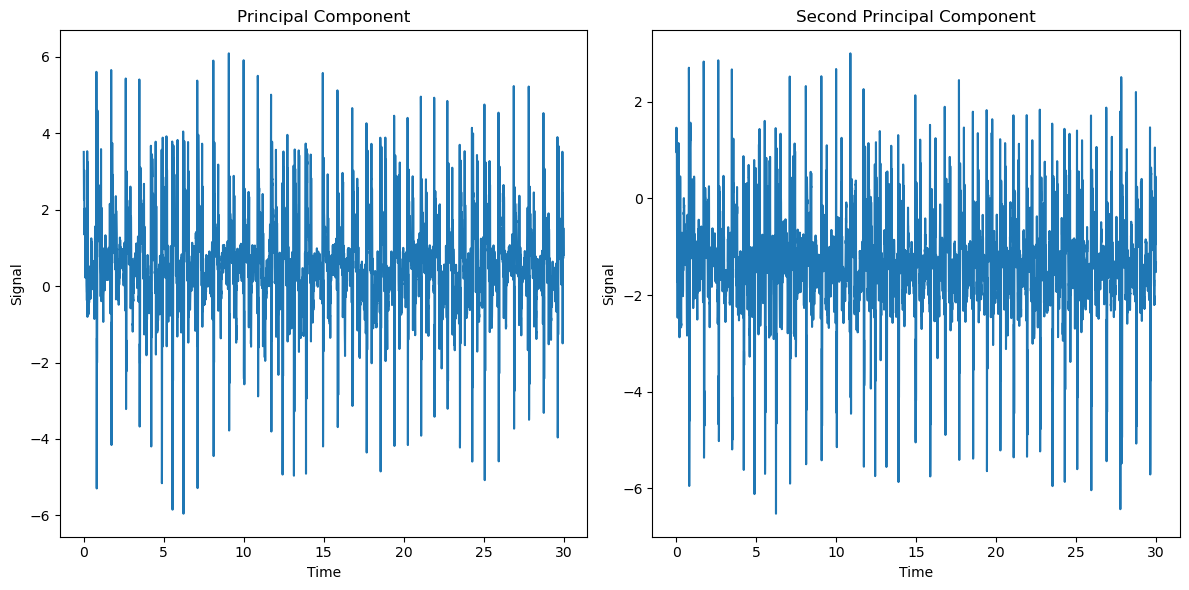

Descriptive Statistics of the First File:

Accellerations:
Mean: 
 -572.3891884233051 -371.3237454986328
Mode: 
 -571.6596987020406 -370.86747825507496
Median: 
 -572.7287467637842 -371.2511895572333
Variance: 
 150.14300015492387 40.66329073704151
Standard Deviation: 
 12.253285280075865 6.376777457073557
25th Percentiles: 
 -580.1718455212738 -375.2017395857533
75th Percentiles: 
 -564.9213943348699 -367.2225729537518
Correlation Coefficient: 
 0.5147391530401783

Angular Velocity:
Mean: 
 0.5697374083400535 -1.3585440713623977
Mode: 
 0.7510814726623462 -1.2530572241414422
Median: 
 0.5129426196322739 -1.4024171149232507
Variance: 
 1.4593458696590682 1.0618760958574283
Standard Deviation: 
 1.208033885973017 1.0304737240014556
25th Percentiles: 
 -0.026553361635515388 -1.843168227800721
75th Percentiles: 
 1.0722337412523342 -0.8696287896903487
Correlation Coefficient: 
 0.7894208895956922


In [7]:
df1, logFreq1=load_txt('center_sternum.txt', 2000, 8000)

subplot_signals(df1, logFreq1,"a")

X1=df1[["AccX","AccY","AccZ"]].to_numpy()
eigenvalues1, eigenvectors1, explained_variance_ratio1 = pca_eigenvalue_decomposition(X1)
X_pca_Acc1 = np.dot(X1, eigenvectors1[:, :2])
    
print("Variance of Accelleration mantained after PCA: ", str(explained_variance_ratio1[0]+explained_variance_ratio1[1])) 

scatter_pca(X_pca_Acc1)
plot_princ_pca(X_pca_Acc1,"Acc","a")

X1g=df1[["GyroX", "GyroY", "GyroZ"]].values
eigenvalues1g, eigenvectors1g, explained_variance_ratio1g = pca_eigenvalue_decomposition(X1g)
X_pca_Gyro1 = np.dot(X1g, eigenvectors1g[:, :2])
    
print("Variance of Angular Velocity mantained after PCA: ", str(explained_variance_ratio1g[0]+explained_variance_ratio1g[1]))

scatter_pca(X_pca_Gyro1)
plot_princ_pca(X_pca_Gyro1,"Gyro","a")
    
print('Descriptive Statistics of the First File:\n\nAccellerations:')
stats1_acc = descriptive_statistics(X_pca_Acc1, stampa = True)
print('\nAngular Velocity:')
stats1_g = descriptive_statistics(X_pca_Gyro1, stampa = True)

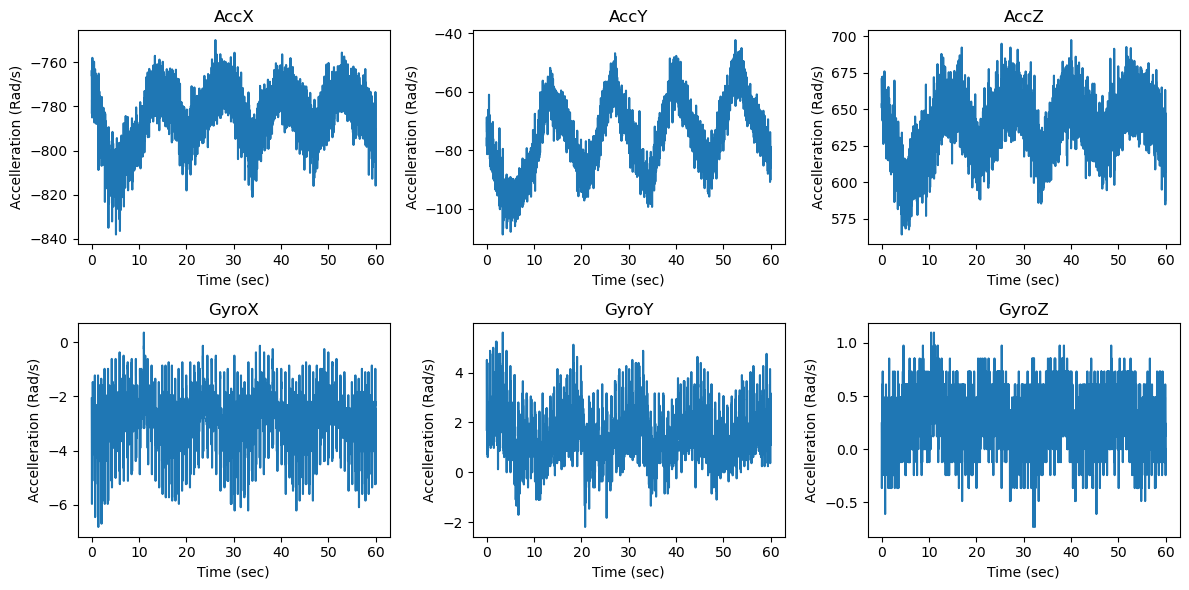

Variance of Accelleration mantained after PCA:  0.933578942104647


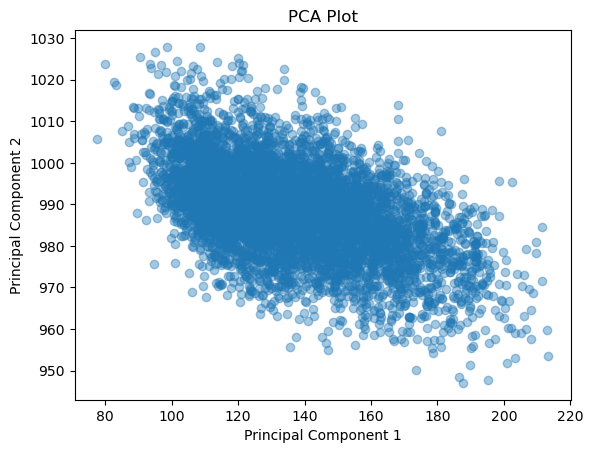

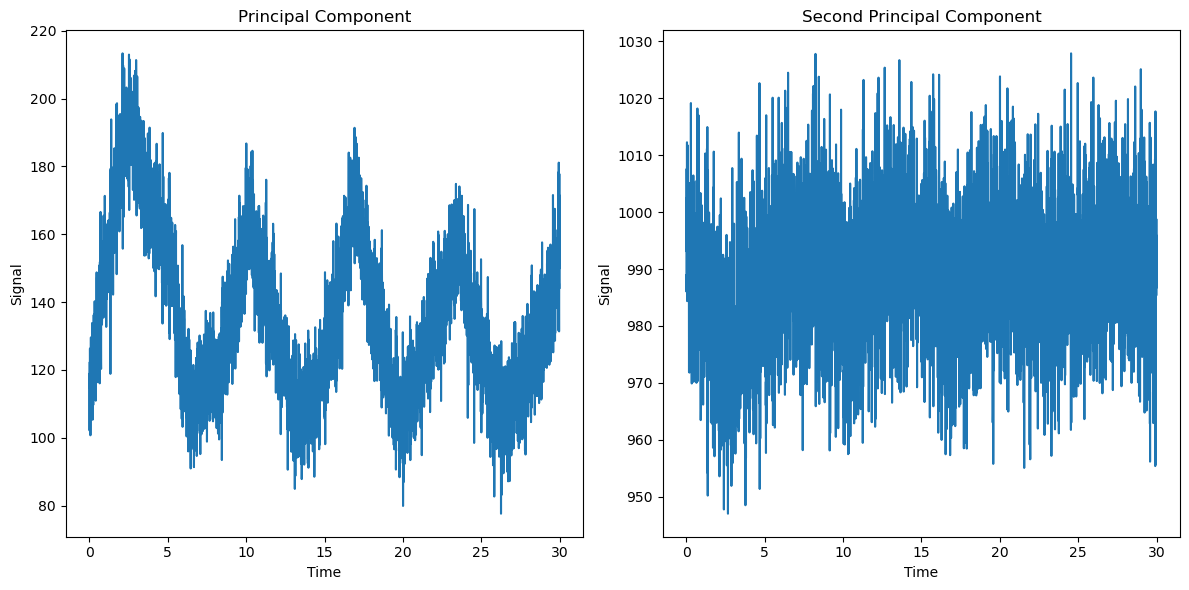

Variance of Angular Velocity mantained after PCA:  0.850851273778178


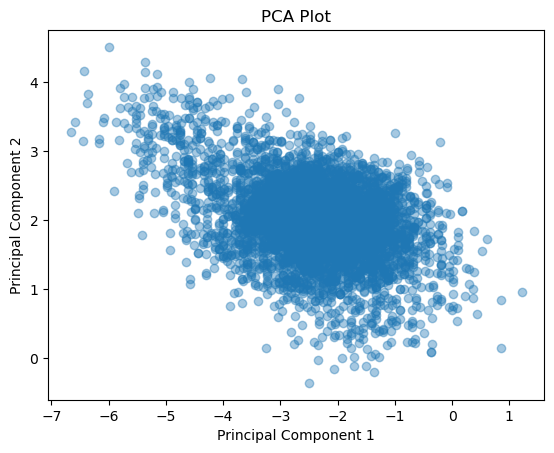

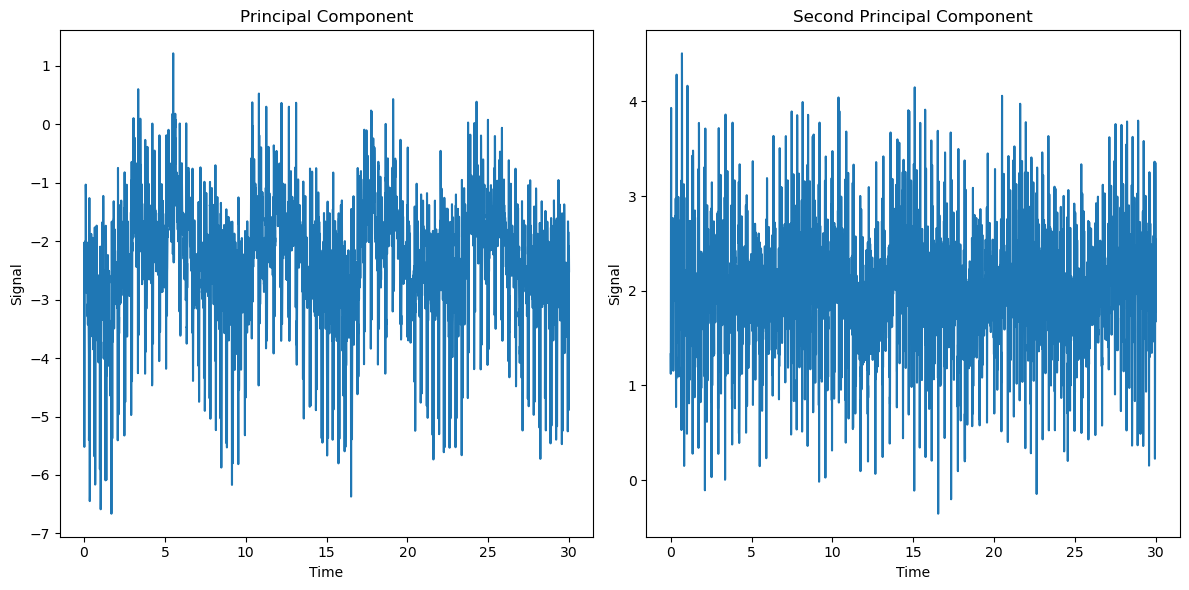

Descriptive Statistics of the First File:

Accellerations:
Mean: 
 135.9354832980632 988.8107035784288
Mode: 
 117.15067807797229 988.9182080878332
Median: 
 132.5678671373393 989.2658756044634
Variance: 
 549.6406059119404 122.5632180967376
Standard Deviation: 
 23.44441523928333 11.070827344726212
25th Percentiles: 
 117.41521312030574 981.8728539477459
75th Percentiles: 
 151.80505964943094 995.6113548966358
Correlation Coefficient: 
 -0.5226517452875009

Angular Velocity:
Mean: 
 -2.3618165538093883 2.014358940004055
Mode: 
 -2.291305428190302 2.2643142170536223
Median: 
 -2.300613470147987 2.033071344161198
Variance: 
 0.9076557608225709 0.2937533942733897
Standard Deviation: 
 0.9527096938850632 0.541990216031055
25th Percentiles: 
 -2.862039963260366 1.7238175393195592
75th Percentiles: 
 -1.7369809446709807 2.3015499027310455
Correlation Coefficient: 
 -0.41109508358646885


In [8]:
file1 = '1_Stave_supine_static.txt'
file2 = '2_Mattress_supine.txt'
file3 = '3_Subject_sitting_chair.txt'
file4 = '4_Chest_sweater.txt'
file5 = '5_Under_chair.txt'

df2, logFreq2=load_txt(file4, 2000, 8000)
    
subplot_signals(df2,logFreq2,"b")
    
X2=df2[["AccX","AccY","AccZ"]].values
eigenvalues2, eigenvectors2, explained_variance_ratio2 = pca_eigenvalue_decomposition(X2)
X_pca_Acc2 = np.dot(X2, eigenvectors2[:, :2])
    
print("Variance of Accelleration mantained after PCA: ", str(explained_variance_ratio2[0]+explained_variance_ratio2[1]))
    
scatter_pca(X_pca_Acc2)
plot_princ_pca(X_pca_Acc2,"Acc","b")
    
X2g=df2[["GyroX", "GyroY", "GyroZ"]].values
eigenvalues2g, eigenvectors2g, explained_variance_ratio2g = pca_eigenvalue_decomposition(X2g)
X_pca_Gyro2 = np.dot(X2g, eigenvectors2g[:, :2])
    
print("Variance of Angular Velocity mantained after PCA: ", str(explained_variance_ratio2g[0]+explained_variance_ratio2g[1]))
    
scatter_pca(X_pca_Gyro2)
plot_princ_pca(X_pca_Gyro2,"Gyro","b")
    
print('Descriptive Statistics of the First File:\n\nAccellerations:')
stats2_acc = descriptive_statistics(X_pca_Acc2, stampa = True)
print('\nAngular Velocity:')
stats2_g = descriptive_statistics(X_pca_Gyro2, stampa = True)

 We can easily notice that, in both files and for all the quantities (Accelleration and Angular Velocity), the two components have **the same mean, mode and median**. This is clearly a sign that the data are distributed according to a **normal distribution (or gaussian)**. For this reason, the most informative descriptors for this type of data, so the descriptors used to represent a normal distribution, are the **Mean and the Standard Deviation** for every component of every quantity. 

If the data would have not been normally distributed, the the best statistical descriptors would have been the percentiles and median. 

### Apply Fourier transform on datas

After that, we can move and evaluate the spectral content of our signals. In order to do that we are going to use fft_transform(), previously defined, and apply it to both dataframes.
Firstly we perform FFT on the mandatory file:

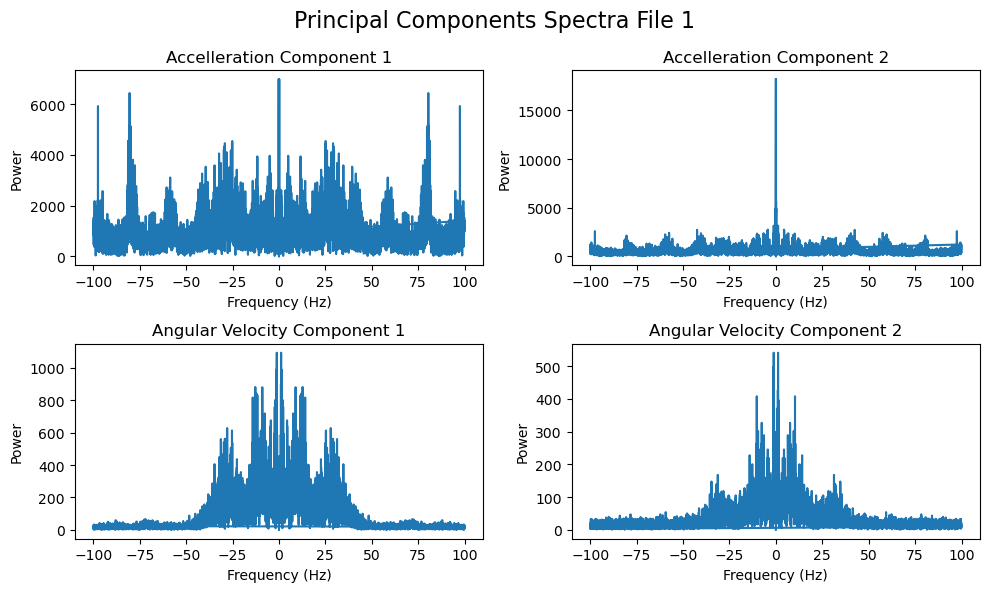

In [9]:
X_pca_Acc1_comp1_fft, X_pca_Acc1_comp2_fft, peak_freq_Acc1_comp1, peak_freq_Acc1_comp2, freqs_Acc1 = fft_transform(X_pca_Acc1, logFreq1)
X_pca_Gyro1_comp1_fft, X_pca_Gyro1_comp2_fft, peak_freq_Gyro1_comp1, peak_freq_Gyro1_comp2, freqs_Gyro1 = fft_transform(X_pca_Gyro1, logFreq1)

X_pca_Acc1_comp1_fft[0] = 0
X_pca_Acc1_comp2_fft[0] = 0
X_pca_Gyro1_comp1_fft[0] = 0
X_pca_Gyro1_comp2_fft[0] = 0

fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 6))
axes[0,0].plot(freqs_Acc1, X_pca_Acc1_comp1_fft)
axes[0,0].set_xlabel('Frequency (Hz)')
axes[0,0].set_ylabel('Power')
axes[0,0].set_title('Accelleration Component 1')
axes[0,1].plot(freqs_Acc1, X_pca_Acc1_comp2_fft)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')
axes[0,1].set_title('Accelleration Component 2')
axes[1,0].plot(freqs_Gyro1, X_pca_Gyro1_comp1_fft)
axes[1,0].set_xlabel('Frequency (Hz)')
axes[1,0].set_ylabel('Power')
axes[1,0].set_title('Angular Velocity Component 1')
axes[1,1].plot(freqs_Gyro1, X_pca_Gyro1_comp2_fft)
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_title('Angular Velocity Component 2')
fig.suptitle('Principal Components Spectra File 1', fontsize = 16)
plt.tight_layout()

And then on the second one:

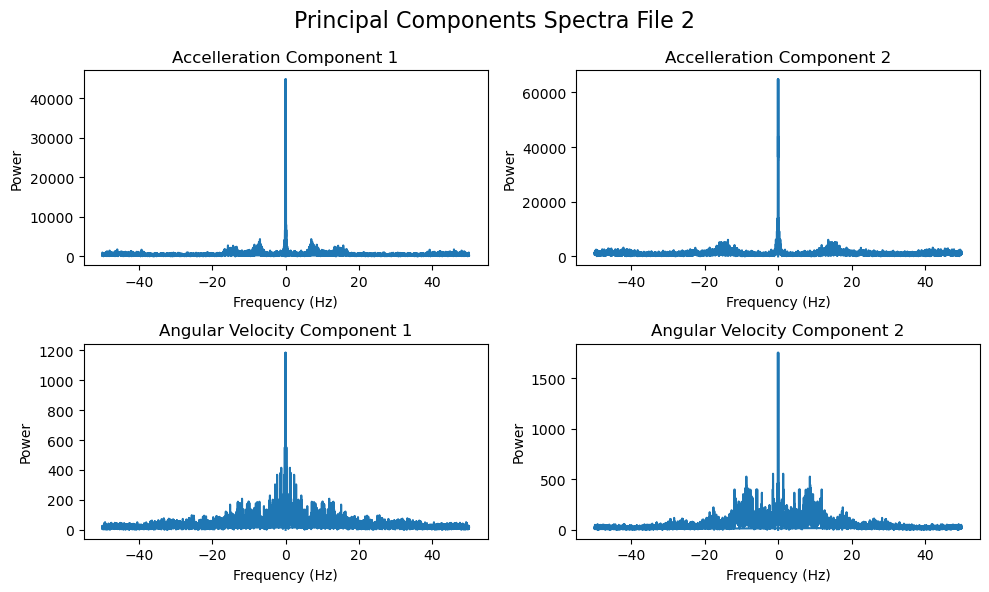

In [10]:
X_pca_Acc2_comp1_fft, X_pca_Acc2_comp2_fft, peak_freq_Acc2_comp1, peak_freq_Acc2_comp2, freqs_Acc2 = fft_transform(X_pca_Acc2, logFreq2)
X_pca_Gyro2_comp1_fft, X_pca_Gyro2_comp2_fft, peak_freq_Gyro2_comp1, peak_freq_Gyro2_comp2, freqs_Gyro2 = fft_transform(X_pca_Gyro2, logFreq2)

#Remove the DC Component
X_pca_Acc2_comp1_fft[0] = 0
X_pca_Acc2_comp2_fft[0] = 0
X_pca_Gyro2_comp1_fft[0] = 0
X_pca_Gyro2_comp2_fft[0] = 0


fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 6))
axes[0,0].plot(freqs_Acc2, X_pca_Acc2_comp1_fft)
axes[0,0].set_xlabel('Frequency (Hz)')
axes[0,0].set_ylabel('Power')
axes[0,0].set_title('Accelleration Component 1')
axes[0,1].plot(freqs_Acc2, X_pca_Acc2_comp2_fft)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')
axes[0,1].set_title('Accelleration Component 2')
axes[1,0].plot(freqs_Gyro2, X_pca_Gyro2_comp1_fft)
axes[1,0].set_xlabel('Frequency (Hz)')
axes[1,0].set_ylabel('Power')
axes[1,0].set_title('Angular Velocity Component 1')
axes[1,1].plot(freqs_Gyro2, X_pca_Gyro2_comp2_fft)
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_title('Angular Velocity Component 2')
fig.suptitle('Principal Components Spectra File 2', fontsize = 16)
plt.tight_layout()

#Nota: If the peak at 0 is very large, it can indicate that the signal has a significant DC offset that 
#may need to be removed before further analysis. However, if the peak at 0 is small, it may not 
#be significant and may not affect the interpretation of the signal.

3. Filter:
    
    Implement your own filter, trying to extrapolate the respiratory rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.

In [11]:
#High-Pass Filter
def hpf(sig_fft, freqs, cutoff):
    filt_fft = sig_fft.copy()
    filt_fft[np.abs(freqs) < cutoff] = 0
    return filt_fft

#Low-Pass Filter
def lpf(sig_fft, freqs, cutoff):
    filt_fft = sig_fft.copy()
    filt_fft[np.abs(freqs) > cutoff] = 0
    return filt_fft

#The combination of the two enables to implement a band-pass filter

We want to find the possible frequency of RR by observing the peaks of spectrum. What we find is that:

In [12]:
print("Peaks on file nr.1")
peak_acc1_comp1 = freqs_Acc1[X_pca_Acc1_comp1_fft.argmax()]
print(peak_acc1_comp1)

peak_acc1_comp2 = freqs_Acc1[X_pca_Acc1_comp2_fft[0:5].argmax()]
print(peak_acc1_comp2)

peak_gyro1_comp1 = freqs_Gyro1[X_pca_Gyro1_comp1_fft.argmax()]
print(peak_gyro1_comp1)

peak_gyro1_comp2 = freqs_Gyro1[X_pca_Gyro1_comp2_fft.argmax()]
print(peak_gyro1_comp2)

Peaks on file nr.1
0.16666666666666666
0.03333333333333333
1.1666666666666667
1.1666666666666667


In [13]:
print("Peaks on file nr.2")
peak_acc2_comp1 = freqs_Acc2[X_pca_Acc2_comp1_fft.argmax()]
print(peak_acc2_comp1)

peak_acc2_comp2 = freqs_Acc2[X_pca_Acc2_comp2_fft[0:5].argmax()]
print(peak_acc2_comp2)

peak_gyro2_comp1 = freqs_Gyro2[X_pca_Gyro2_comp1_fft.argmax()]
print(peak_gyro2_comp1)

peak_gyro2_comp2 = freqs_Gyro2[X_pca_Gyro2_comp2_fft.argmax()]
print(peak_gyro2_comp2)

Peaks on file nr.2
0.06666666666666667
0.06666666666666667
0.06666666666666667
0.06666666666666667


According to literature, a band-pass configuration is the best choice, since in this way it's possible to remove the slow frequency variations unrelated to the respiratory movements and the high frequency, corresponding to the cardiac activity and noise.

We can state that the Respiratory frequency will probably be around 0.2. So, after comparing the shapes of 4 components (2 for each quantity) spectra (in particular the peaks in the region between 0.2 and 0.05), we try to  filter our signals around common peaks and see what happens. The result displayed are obtained after applying different filters configuration, in order to select different peaks of the spectra, and choosing the best. 

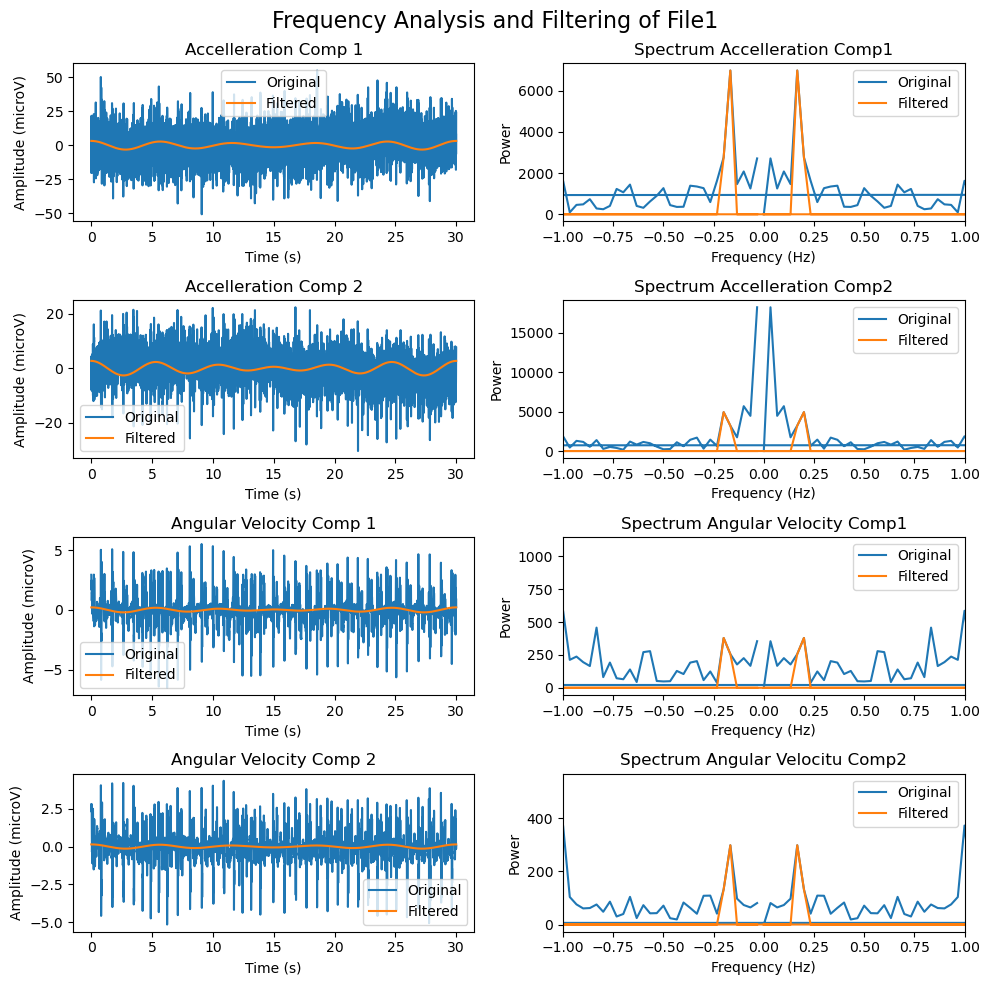

In [14]:
X_pca_Acc1_comp1_filt_fft = hpf(lpf(X_pca_Acc1_comp1_fft, freqs_Acc1, 0.2), freqs_Acc1, 0.15)
X_pca_Acc1_comp1_filtered = np.real(fftpack.ifft(X_pca_Acc1_comp1_filt_fft))

X_pca_Acc1_comp2_filt_fft = hpf(lpf(X_pca_Acc1_comp2_fft, freqs_Acc1, 0.2), freqs_Acc1, 0.15)
X_pca_Acc1_comp2_filtered = np.real(fftpack.ifft(X_pca_Acc1_comp2_filt_fft))

X_pca_Gyro1_comp1_filt_fft = hpf(lpf(X_pca_Gyro1_comp1_fft, freqs_Gyro1, 0.2), freqs_Gyro1, 0.15) 
X_pca_Gyro1_comp1_filtered = np.real(fftpack.ifft(X_pca_Gyro1_comp1_filt_fft))

X_pca_Gyro1_comp2_filt_fft = hpf(lpf(X_pca_Gyro1_comp2_fft, freqs_Gyro1, 0.2), freqs_Acc1, 0.15)
X_pca_Gyro1_comp2_filtered = np.real(fftpack.ifft(X_pca_Gyro1_comp2_filt_fft))

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10,10))
t = np.arange(0, X_pca_Gyro1.shape[0] * 1/logFreq1, 1/logFreq1)
axes[2, 0].plot(t, X_pca_Gyro1.T[0,:] - np.mean(X_pca_Gyro1.T[0,:]), label='Original')
axes[2,0].plot(t, X_pca_Gyro1_comp1_filtered, label='Filtered')
axes[2,0].legend()
axes[2,0].set_title('Angular Velocity Comp 1')
axes[2,0].set_xlabel('Time (s)')
axes[2,0].set_ylabel('Amplitude (microV)')

axes[3, 0].plot(t, X_pca_Gyro1.T[1,:] - np.mean(X_pca_Gyro1.T[1,:]), label='Original')
axes[3,0].plot(t, X_pca_Gyro1_comp2_filtered, label='Filtered')
axes[3,0].legend()
axes[3,0].set_title('Angular Velocity Comp 2')
axes[3,0].set_xlabel('Time (s)')
axes[3,0].set_ylabel('Amplitude (microV)')


axes[2, 1].plot(freqs_Gyro1, X_pca_Gyro1_comp1_fft, label='Original')
axes[2,1].plot(freqs_Gyro1, X_pca_Gyro1_comp1_filt_fft, label='Filtered')
axes[2,1].legend()
axes[2,1].set_title('Spectrum Angular Velocity Comp1')
axes[2,1].set_xlabel('Frequency (Hz)')
axes[2,1].set_ylabel('Power')
axes[2,1].set_xlim(-1, 1)

axes[3, 1].plot(freqs_Gyro1, X_pca_Gyro1_comp2_fft, label='Original')
axes[3,1].plot(freqs_Gyro1, X_pca_Gyro1_comp2_filt_fft, label='Filtered')
axes[3,1].legend()
axes[3,1].set_title('Spectrum Angular Velocitu Comp2')
axes[3,1].set_xlabel('Frequency (Hz)')
axes[3,1].set_ylabel('Power')
axes[3,1].set_xlim(-1,1)

axes[0, 0].plot(t, X_pca_Acc1.T[0,:] - np.mean(X_pca_Acc1.T[0,:]), label='Original')
axes[0,0].plot(t, X_pca_Acc1_comp1_filtered, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration Comp 1')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[1, 0].plot(t, X_pca_Acc1.T[1,:] - np.mean(X_pca_Acc1.T[1,:]), label='Original')
axes[1,0].plot(t, X_pca_Acc1_comp2_filtered, label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Accelleration Comp 2')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[0, 1].plot(freqs_Acc1, X_pca_Acc1_comp1_fft, label='Original')
axes[0,1].plot(freqs_Acc1, X_pca_Acc1_comp1_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration Comp1')
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')
axes[0,1].set_xlim(-1,1)

axes[1, 1].plot(freqs_Acc1, X_pca_Acc1_comp2_fft, label='Original')
axes[1,1].plot(freqs_Acc1, X_pca_Acc1_comp2_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Accelleration Comp2')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_xlim(-1,1)

fig.suptitle('Frequency Analysis and Filtering of File1', fontsize=16)
plt.tight_layout()

And we do the same thing for file number 2:

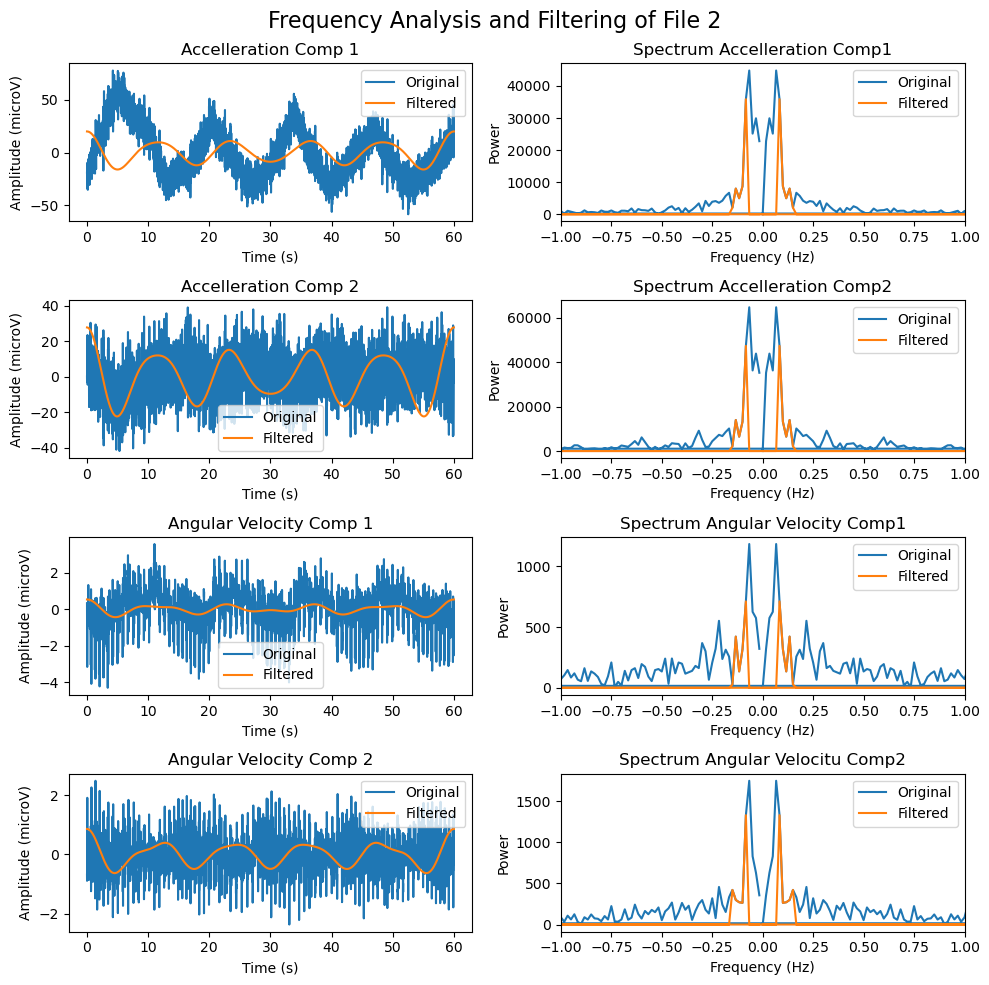

In [15]:
X_pca_Acc2_comp1_filt_fft = hpf(lpf(X_pca_Acc2_comp1_fft, freqs_Acc2, 0.15), freqs_Acc2, 0.07) 
X_pca_Acc2_comp1_filtered = np.real(fftpack.ifft(X_pca_Acc2_comp1_filt_fft))

X_pca_Acc2_comp2_filt_fft = hpf(lpf(X_pca_Acc2_comp2_fft, freqs_Acc2, 0.15), freqs_Acc2, 0.07)
X_pca_Acc2_comp2_filtered = np.real(fftpack.ifft(X_pca_Acc2_comp2_filt_fft))

X_pca_Gyro2_comp1_filt_fft = hpf(lpf(X_pca_Gyro2_comp1_fft, freqs_Gyro2, 0.15), freqs_Gyro2, 0.07)
X_pca_Gyro2_comp1_filtered = np.real(fftpack.ifft(X_pca_Gyro2_comp1_filt_fft))

X_pca_Gyro2_comp2_filt_fft = hpf(lpf(X_pca_Gyro2_comp2_fft, freqs_Gyro2, 0.15), freqs_Acc2, 0.07)
X_pca_Gyro2_comp2_filtered = np.real(fftpack.ifft(X_pca_Gyro2_comp2_filt_fft))

fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (10,10))
t = np.arange(0, X_pca_Gyro2.shape[0] * 1/logFreq2, 1/logFreq2)

axes[2, 0].plot(t, X_pca_Gyro2.T[0,:] - np.mean(X_pca_Gyro2.T[0,:]), label='Original')
axes[2,0].plot(t, X_pca_Gyro2_comp1_filtered, label='Filtered')
axes[2,0].legend()
axes[2,0].set_title('Angular Velocity Comp 1')
axes[2,0].set_xlabel('Time (s)')
axes[2,0].set_ylabel('Amplitude (microV)')

axes[3, 0].plot(t, X_pca_Gyro2.T[1,:] - np.mean(X_pca_Gyro2.T[1,:]), label='Original')
axes[3,0].plot(t, X_pca_Gyro2_comp2_filtered, label='Filtered')
axes[3,0].legend()
axes[3,0].set_title('Angular Velocity Comp 2')
axes[3,0].set_xlabel('Time (s)')
axes[3,0].set_ylabel('Amplitude (microV)')

axes[2, 1].plot(freqs_Gyro2, X_pca_Gyro2_comp1_fft, label='Original')
axes[2,1].plot(freqs_Gyro2, X_pca_Gyro2_comp1_filt_fft, label='Filtered')
axes[2,1].legend()
axes[2,1].set_title('Spectrum Angular Velocity Comp1')
axes[2,1].set_xlabel('Frequency (Hz)')
axes[2,1].set_ylabel('Power')
axes[2,1].set_xlim(-1,1)

axes[3, 1].plot(freqs_Gyro2, X_pca_Gyro2_comp2_fft, label='Original')
axes[3,1].plot(freqs_Gyro2, X_pca_Gyro2_comp2_filt_fft, label='Filtered')
axes[3,1].legend()
axes[3,1].set_title('Spectrum Angular Velocitu Comp2')
axes[3,1].set_xlabel('Frequency (Hz)')
axes[3,1].set_ylabel('Power')
axes[3,1].set_xlim(-1,1)

axes[0, 0].plot(t, X_pca_Acc2.T[0,:] - np.mean(X_pca_Acc2.T[0,:]), label='Original')
axes[0,0].plot(t, X_pca_Acc2_comp1_filtered, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration Comp 1')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[1, 0].plot(t, X_pca_Acc2.T[1,:] - np.mean(X_pca_Acc2.T[1,:]), label='Original')
axes[1,0].plot(t, X_pca_Acc2_comp2_filtered , label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Accelleration Comp 2')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[0, 1].plot(freqs_Acc2, X_pca_Acc2_comp1_fft, label='Original')
axes[0,1].plot(freqs_Acc2, X_pca_Acc2_comp1_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration Comp1')
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')
axes[0,1].set_xlim(-1,1)

axes[1, 1].plot(freqs_Acc2, X_pca_Acc2_comp2_fft, label='Original')
axes[1,1].plot(freqs_Acc2, X_pca_Acc2_comp2_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Accelleration Comp2')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_xlim(-1,1)

fig.suptitle('Frequency Analysis and Filtering of File 2', fontsize=16)
plt.tight_layout()

An alternative method can be, instead of using two different components for every quantity on every file, summing the 2 principal components of every signal, in order to have a more robust signal:

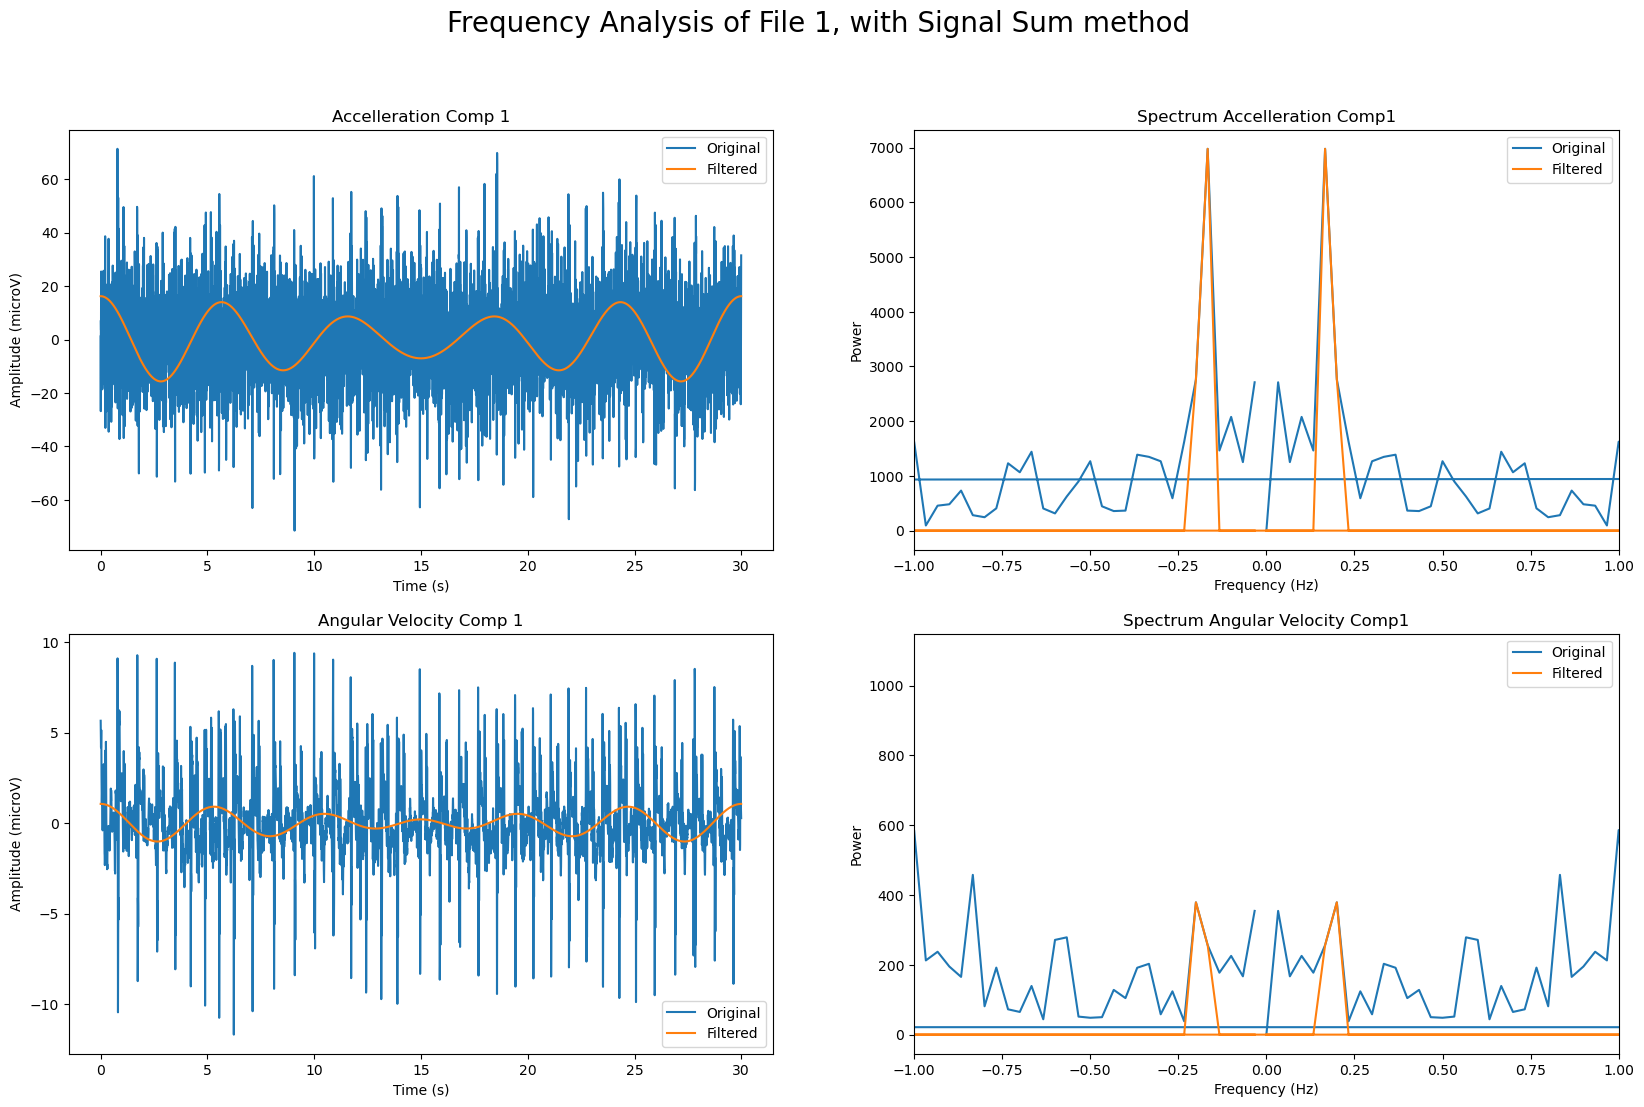

In [16]:
factor = 5 #only for visualization aims

acc1 = X_pca_Acc1[:,0] + X_pca_Acc1[:,1]
gyro1 = X_pca_Gyro1[:,0] + X_pca_Gyro1[:,1]
acc1_fft = np.abs(fftpack.fft(acc1))
acc1_fft[0] = 0
freqs_acc1 = fftpack.fftfreq(acc1.shape[0], d=1/logFreq1)
gyro1_fft = np.abs(fftpack.fft(gyro1))
gyro1_fft[0] = 0
freqs_gyro1 = fftpack.fftfreq(gyro1.shape[0], d = 1/logFreq1)

acc1_filt_fft = hpf(lpf(acc1_fft, freqs_acc1, 0.2), freqs_acc1, 0.15) 
acc1_filt = np.real(fftpack.ifft(acc1_filt_fft))
gyro1_filt_fft = hpf(lpf(gyro1_fft, freqs_gyro1, 0.2), freqs_gyro1, 0.15) 
gyro1_filt = np.real(fftpack.ifft(gyro1_filt_fft))

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
t = np.arange(0, X_pca_Acc1.shape[0] * 1/logFreq1, 1/logFreq1)

axes[0,0].plot(t, acc1 - np.mean(acc1), label='Original')
axes[0,0].plot(t, acc1_filt*factor, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration Comp 1')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[0,1].plot(freqs_acc1, acc1_fft, label='Original')
axes[0,1].plot(freqs_acc1, acc1_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration Comp1')
axes[0,1].set_xlim(-1,1)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')

axes[1,0].plot(t, gyro1 - np.mean(gyro1), label='Original')
axes[1,0].plot(t, gyro1_filt*factor, label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Angular Velocity Comp 1')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[1,1].plot(freqs_gyro1, gyro1_fft, label='Original')
axes[1,1].plot(freqs_gyro1, gyro1_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Angular Velocity Comp1')
axes[1,1].set_xlim(-1,1)
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')

fig.suptitle('Frequency Analysis of File 1, with Signal Sum method', fontsize = 20)
plt.show()

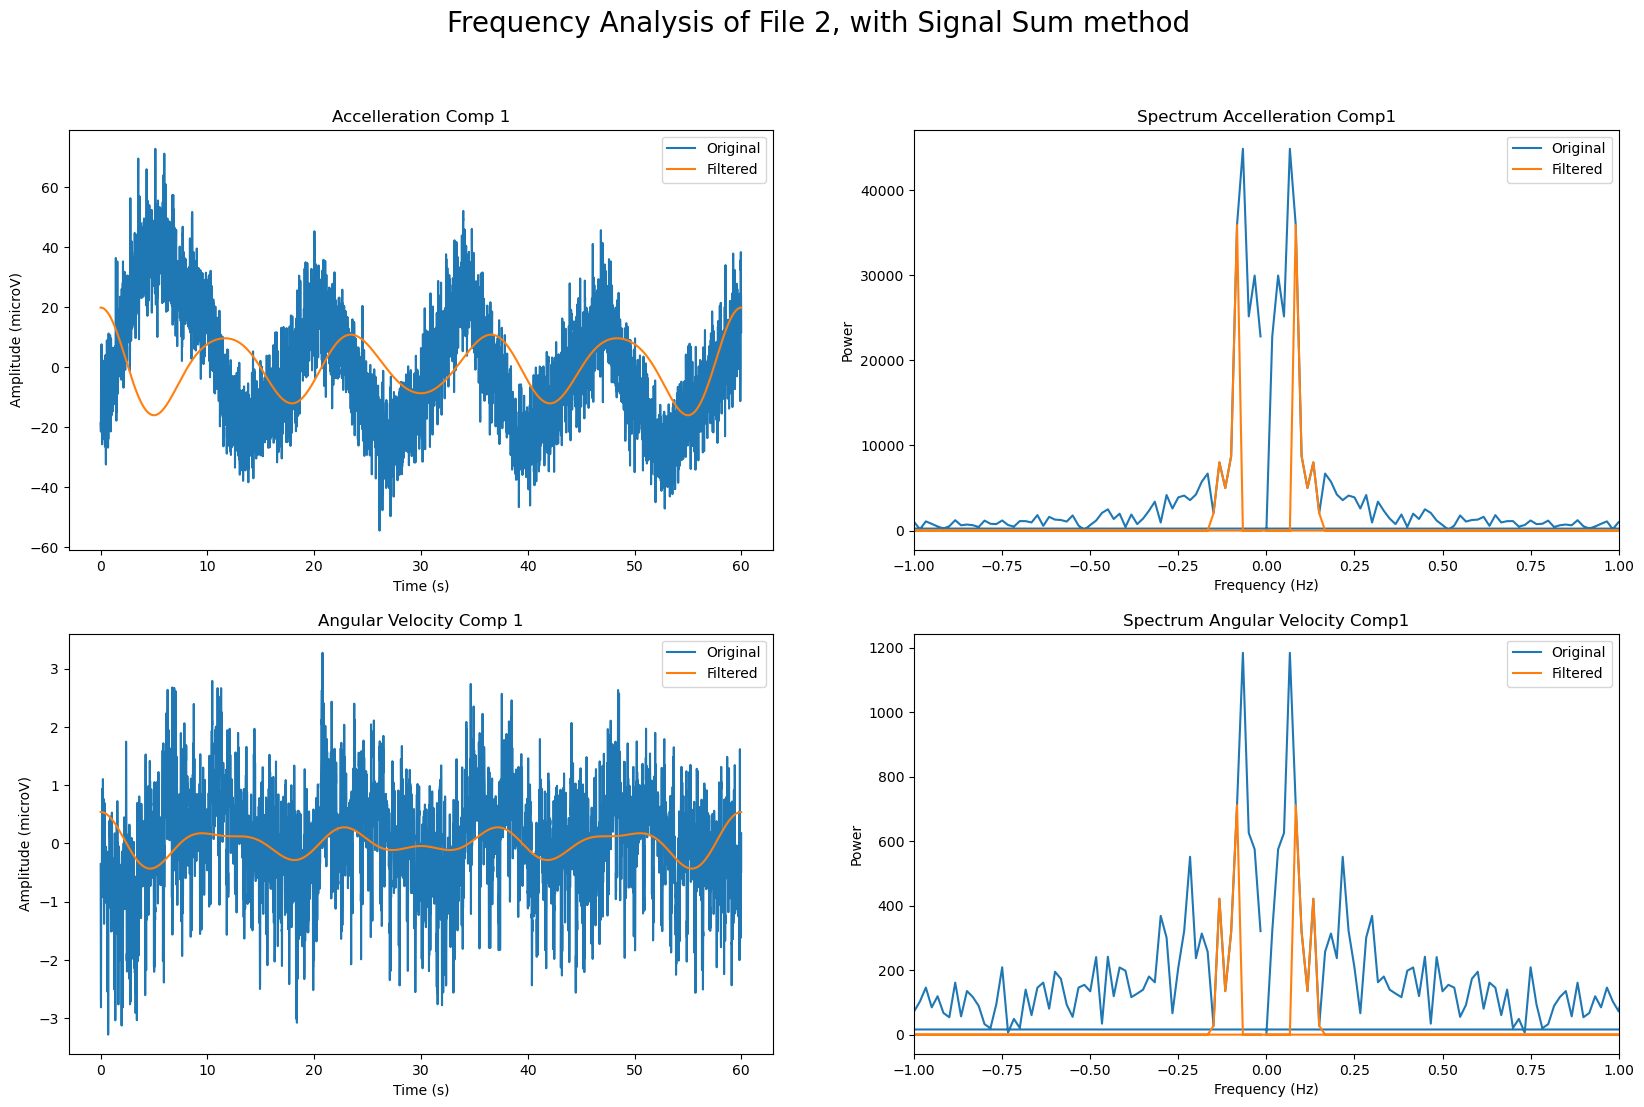

In [17]:
acc2 = X_pca_Acc2[:,0] + X_pca_Acc2[:,1]
gyro2 = X_pca_Gyro2[:,0] + X_pca_Gyro2[:,1]
acc2_fft = np.abs(fftpack.fft(acc2))
acc2_fft[0] = 0
freqs_acc2 = fftpack.fftfreq(acc2.shape[0], d=1/logFreq2)
gyro2_fft = np.abs(fftpack.fft(gyro2))
gyro2_fft[0] = 0
freqs_gyro2 = fftpack.fftfreq(gyro2.shape[0], d = 1/logFreq2)

acc2_filt_fft = hpf(lpf(acc2_fft, freqs_acc2, 0.15), freqs_acc2, 0.07) 
acc2_filt = np.real(fftpack.ifft(acc2_filt_fft))
gyro2_filt_fft = hpf(lpf(gyro2_fft, freqs_gyro2, 0.15), freqs_gyro2, 0.07) 
gyro2_filt = np.real(fftpack.ifft(gyro2_filt_fft))

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
t = np.arange(0, X_pca_Acc2.shape[0] * 1/logFreq2, 1/logFreq2)

axes[0,0].plot(t, acc2 - np.mean(acc2), label='Original')
axes[0,0].plot(t, acc2_filt, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration Comp 1')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[0,1].plot(freqs_acc2, acc2_fft, label='Original')
axes[0,1].plot(freqs_acc2, acc2_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration Comp1')
axes[0,1].set_xlim(-1,1)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')

axes[1,0].plot(t, gyro2 - np.mean(gyro2), label='Original')
axes[1,0].plot(t, gyro2_filt, label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Angular Velocity Comp 1')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[1,1].plot(freqs_gyro2, gyro2_fft, label='Original')
axes[1,1].plot(freqs_gyro2, gyro2_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Angular Velocity Comp1')
axes[1,1].set_xlim(-1,1)
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')

fig.suptitle('Frequency Analysis of File 2, with Signal Sum method', fontsize = 20)
plt.show()

Or, instead of the sum of the signals, we apply the sum to the  2 FFT of the principal components of every signal, in order to reconstuct a more robust signal. In fact, in this way the spectrum's peaks are much more evident.

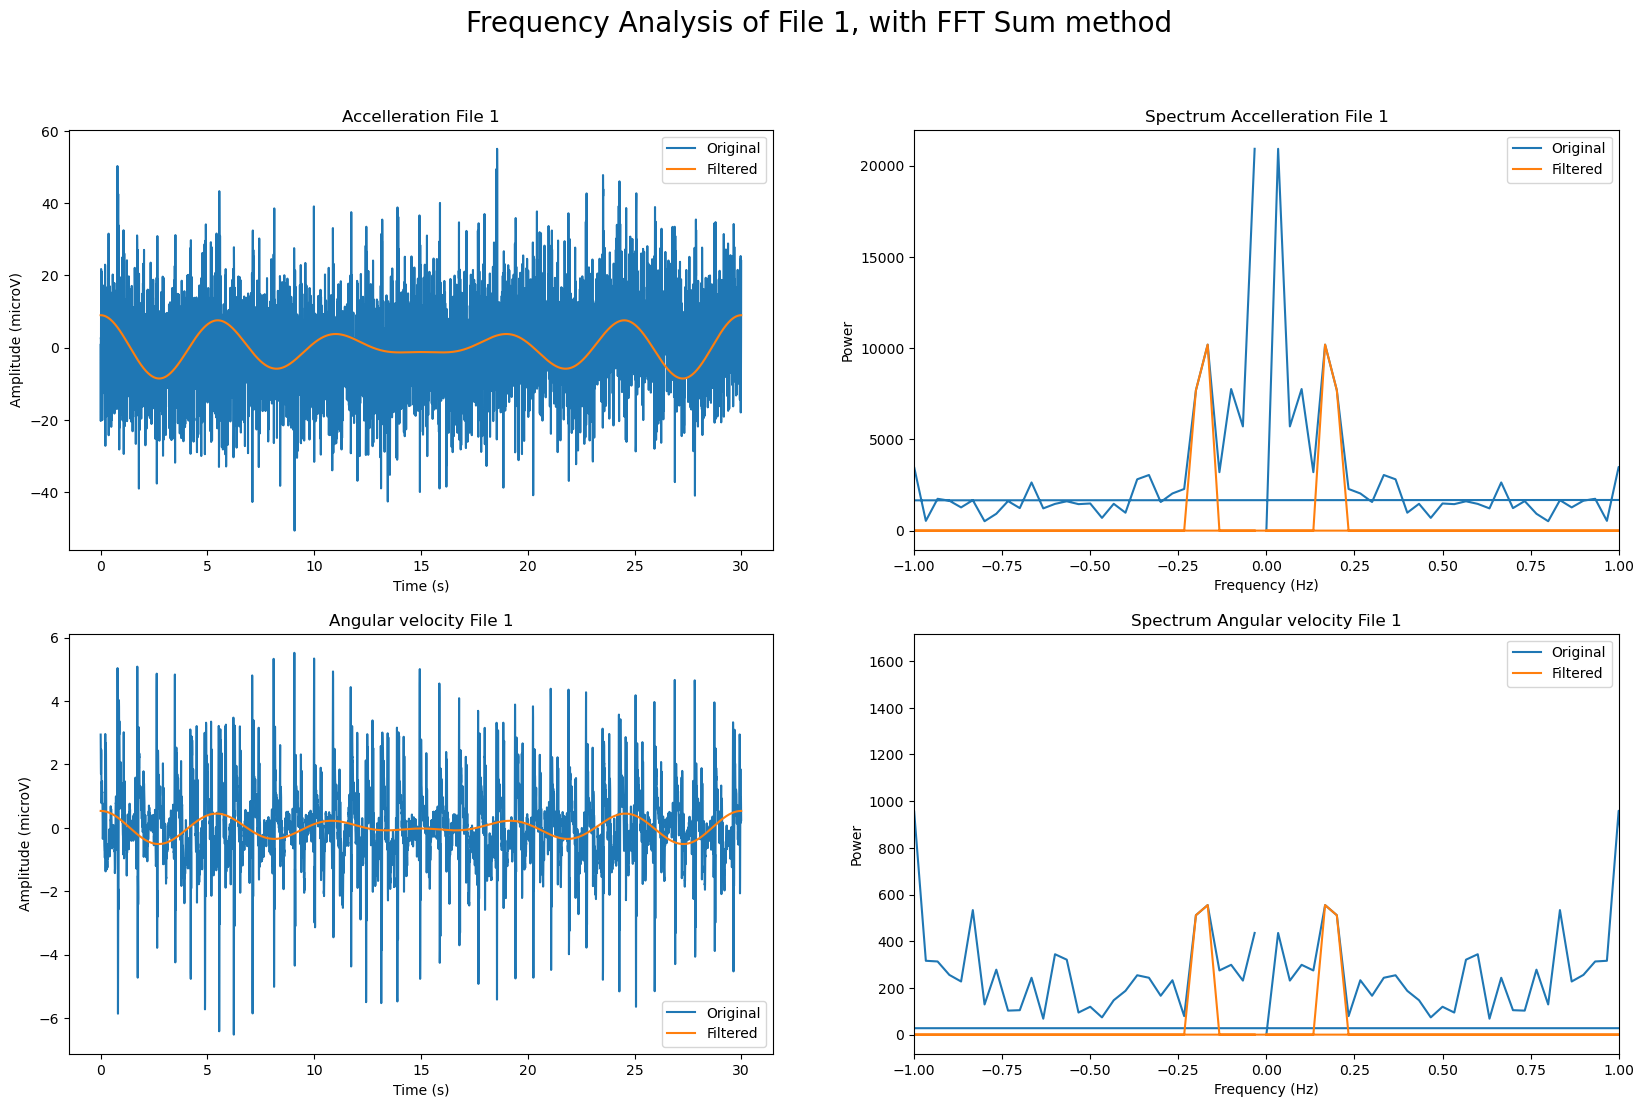

In [18]:
factor = 1.5

X_pca_Acc1_fft=X_pca_Acc1_comp1_fft+X_pca_Acc1_comp2_fft

X_pca_Acc1_filt_fft = hpf(lpf(X_pca_Acc1_fft, freqs_Acc1, 0.2), freqs_Acc1, 0.15)
X_pca_Acc1_filtered = np.real(fftpack.ifft(X_pca_Acc1_filt_fft))

X_pca_Gyro1_fft=X_pca_Gyro1_comp1_fft+X_pca_Gyro1_comp2_fft

X_pca_Gyro1_filt_fft = hpf(lpf(X_pca_Gyro1_fft, freqs_Gyro1, 0.2), freqs_Acc1, 0.15)
X_pca_Gyro1_filtered = np.real(fftpack.ifft(X_pca_Gyro1_filt_fft))

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
t = np.arange(0, X_pca_Acc1.shape[0] * 1/logFreq1, 1/logFreq1)

axes[0, 0].plot(t, X_pca_Acc1.T[0,:]-np.mean(X_pca_Acc1.T[0,:]), label='Original')
axes[0,0].plot(t, X_pca_Acc1_filtered*factor, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration File 1')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[0, 1].plot(freqs_Acc1, X_pca_Acc1_fft, label='Original')
axes[0,1].plot(freqs_Acc1, X_pca_Acc1_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration File 1')
axes[0,1].set_xlim(-1,1)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')

t = np.arange(0, X_pca_Gyro1.shape[0] * 1/logFreq1, 1/logFreq1)

axes[1, 0].plot(t, X_pca_Gyro1.T[0,:]-np.mean(X_pca_Gyro1.T[0,:]), label='Original')
axes[1,0].plot(t, X_pca_Gyro1_filtered*factor, label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Angular velocity File 1')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[1, 1].plot(freqs_Gyro1, X_pca_Gyro1_fft, label='Original')
axes[1,1].plot(freqs_Gyro1, X_pca_Gyro1_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Angular velocity File 1')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_xlim(-1,1)

fig.suptitle('Frequency Analysis of File 1, with FFT Sum method', fontsize = 20)
plt.show()

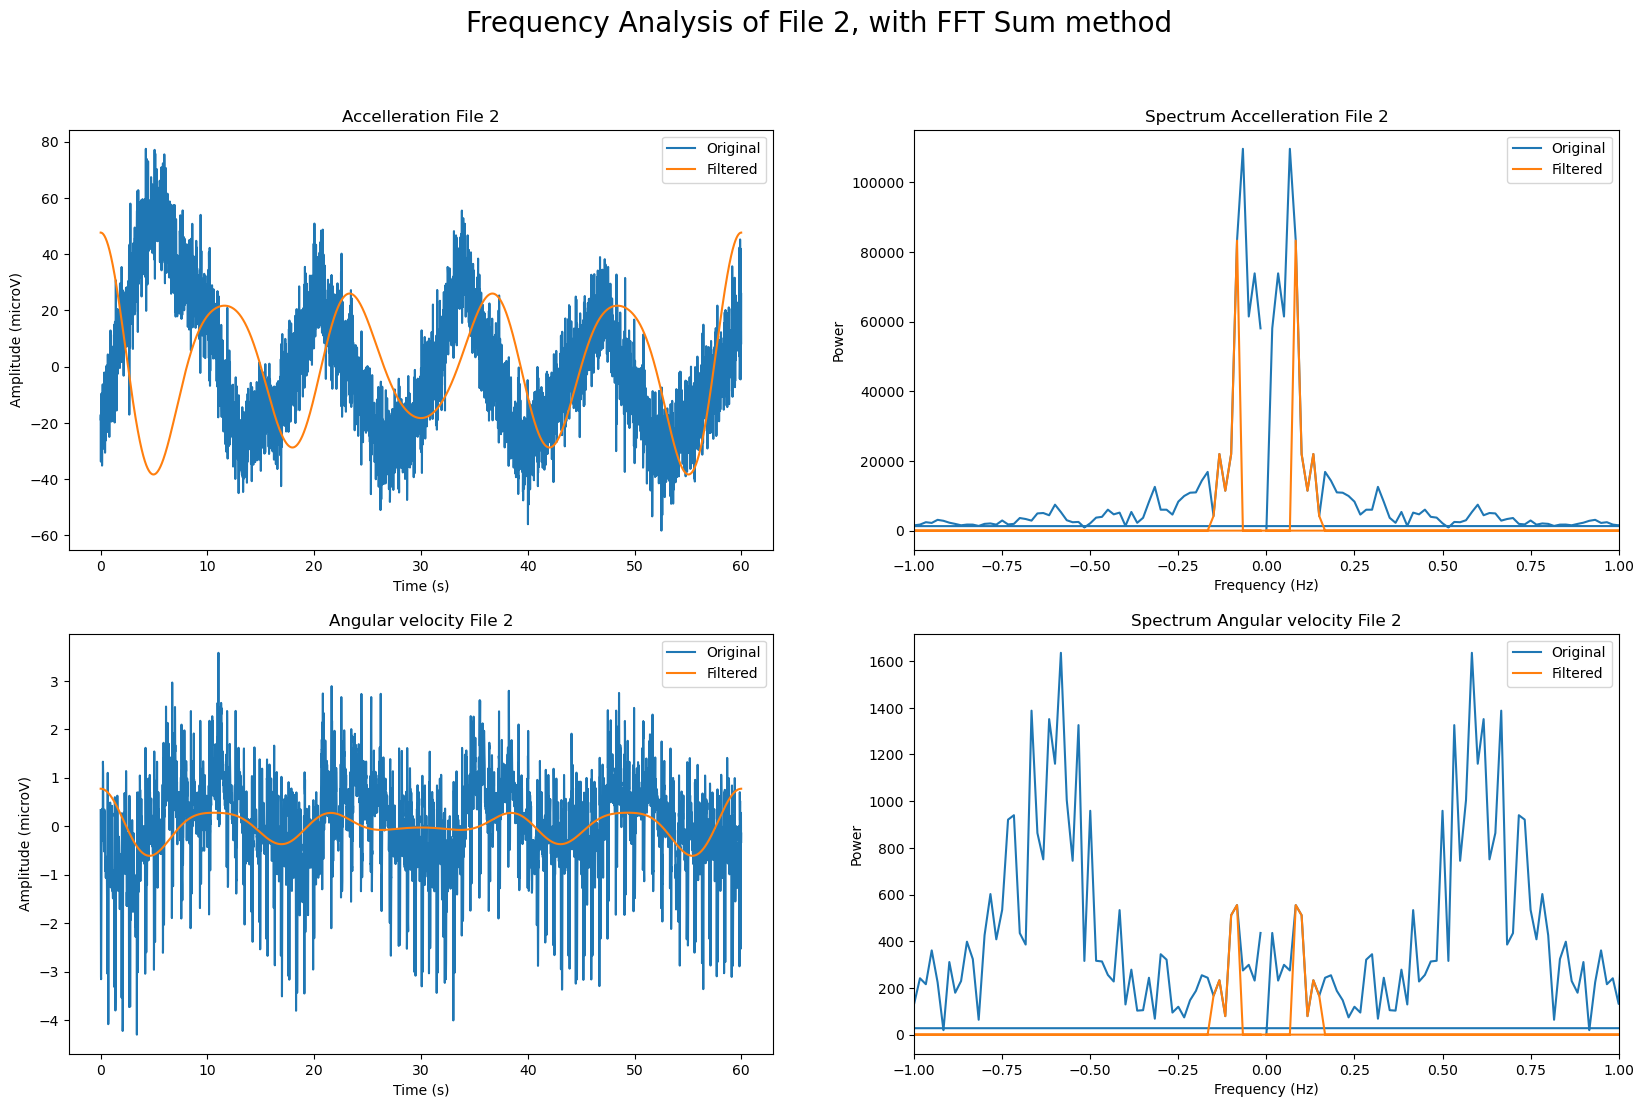

In [19]:
X_pca_Acc2_fft=X_pca_Acc2_comp1_fft+X_pca_Acc2_comp2_fft

X_pca_Acc2_filt_fft = hpf(lpf(X_pca_Acc2_fft, freqs_Acc2, 0.15), freqs_Acc2, 0.07)
X_pca_Acc2_filtered = np.real(fftpack.ifft(X_pca_Acc2_filt_fft))

X_pca_Gyro2_fft=X_pca_Gyro1_comp1_fft+X_pca_Gyro1_comp2_fft

X_pca_Gyro2_filt_fft = hpf(lpf(X_pca_Gyro2_fft, freqs_Gyro2, 0.15), freqs_Acc2, 0.07)
X_pca_Gyro2_filtered = np.real(fftpack.ifft(X_pca_Gyro2_filt_fft))

fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (20,12))
t = np.arange(0, X_pca_Acc2.shape[0] * 1/logFreq2, 1/logFreq2)

axes[0, 0].plot(t, X_pca_Acc2.T[0,:]-np.mean(X_pca_Acc2.T[0,:]), label='Original')
axes[0,0].plot(t, X_pca_Acc2_filtered, label='Filtered')
axes[0,0].legend()
axes[0,0].set_title('Accelleration File 2')
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('Amplitude (microV)')

axes[0, 1].plot(freqs_Acc2, X_pca_Acc2_fft, label='Original')
axes[0,1].plot(freqs_Acc2, X_pca_Acc2_filt_fft, label='Filtered')
axes[0,1].legend()
axes[0,1].set_title('Spectrum Accelleration File 2')
axes[0,1].set_xlim(-1,1)
axes[0,1].set_xlabel('Frequency (Hz)')
axes[0,1].set_ylabel('Power')

t = np.arange(0, X_pca_Gyro2.shape[0] * 1/logFreq2, 1/logFreq2)

axes[1, 0].plot(t, X_pca_Gyro2.T[0,:]-np.mean(X_pca_Gyro2.T[0,:]), label='Original')
axes[1,0].plot(t, X_pca_Gyro2_filtered*factor, label='Filtered')
axes[1,0].legend()
axes[1,0].set_title('Angular velocity File 2')
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('Amplitude (microV)')

axes[1, 1].plot(freqs_Gyro2, X_pca_Gyro2_fft, label='Original')
axes[1,1].plot(freqs_Gyro2, X_pca_Gyro2_filt_fft, label='Filtered')
axes[1,1].legend()
axes[1,1].set_title('Spectrum Angular velocity File 2')
axes[1,1].set_xlabel('Frequency (Hz)')
axes[1,1].set_ylabel('Power')
axes[1,1].set_xlim(-1,1)

fig.suptitle('Frequency Analysis of File 2, with FFT Sum method', fontsize = 20)
plt.show()

4. Metrics:

    4.1. Respiratory Rate Per Minute (RPM): extrapolate RPM, and make an histogram of the result. Does it follow a particular distribution?


In [20]:
def periodi(signal,sampling):
    v=[]
    for i in range(len(signal)):
        if i>1 and i<len(signal)-1:
            if signal[i]>signal[i-1] and signal[i]>signal[i+1]:
                v.append(i/sampling)
    periodi=[]
    for el in range(len(v)):
        if el==0:
            periodi.append(v[el])
        else:
            periodi.append(round(v[el]-v[el-1],1))
    return periodi

def hist_show(periods):
    """
    It shows the histogram without kde and with a chosen number of bins
    """
    plt.hist(periods,bins=12)
    
    plt.xlabel('Periodicity(s)')
    plt.ylabel('Frequency')
    plt.title('Histogram of RPMs periodicity = RRV')

    plt.show()
    
def hist_KDE(periods,name):
    """
    It shows the histogram with kde
    """
    sns.histplot(periods, kde=True)

    plt.xlabel('Periodicity(s)')
    plt.ylabel('Density')
    plt.title("Histogram of "+name+" with KDE")

    plt.show()

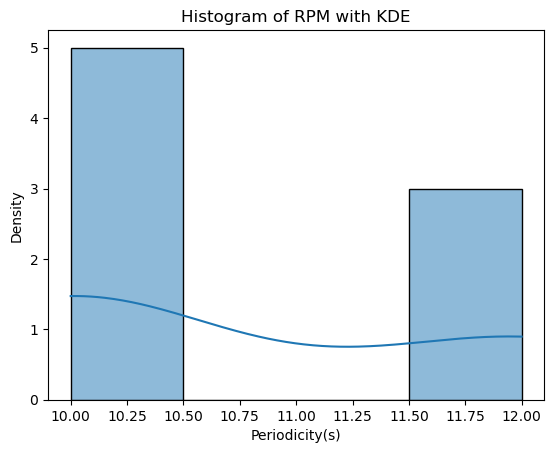

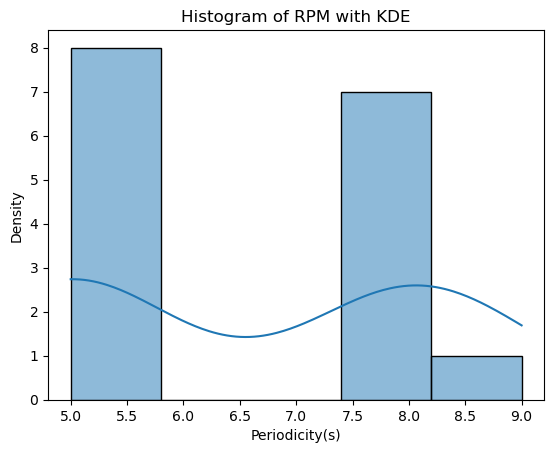

In [21]:
#for subject 1
respiratory_freq_1=np.array([])

#collecting all the data analyzed fot the subject with different methods in a list
s1_data = [X_pca_Acc1_comp1_filt_fft, X_pca_Acc1_comp2_filt_fft, X_pca_Gyro1_comp1_filt_fft, X_pca_Gyro1_comp2_filt_fft, acc1_filt_fft, gyro1_filt_fft, X_pca_Acc1_filt_fft, X_pca_Gyro1_filt_fft]
for s in s1_data:
    peaks, _ = signal.find_peaks(s)
    highest_peak = sorted(peaks, key=lambda x: s[x], reverse=True)
    respiratory_freq_1=np.append(respiratory_freq_1, freqs_acc1[highest_peak])

respiratory_freq_1 = respiratory_freq_1[respiratory_freq_1>0] #since the signal is symmetric in 0 we retain only positive values, otherewise there would be duplicates

RPM_s1 = respiratory_freq_1*60
hist_KDE(RPM_s1,"RPM")

#for subject 2
respiratory_freq_2=np.array([])

s2_data = [X_pca_Acc2_comp1_filt_fft, X_pca_Acc2_comp2_filt_fft, X_pca_Gyro2_comp1_filt_fft, X_pca_Gyro2_comp2_filt_fft, acc2_filt_fft, gyro2_filt_fft, X_pca_Acc2_filt_fft, X_pca_Gyro2_filt_fft]
for s in s2_data:
    peaks, _ = signal.find_peaks(s)
    highest_peak = sorted(peaks, key=lambda x: s[x], reverse=True)
    respiratory_freq_2=np.append(respiratory_freq_2, freqs_acc2[highest_peak])

respiratory_freq_2 = respiratory_freq_2[respiratory_freq_2>0]

RPM_s2 = respiratory_freq_2*60
hist_KDE(RPM_s2,"RPM")



   4.2. Respiratory Rate Variability (RRV): extrapolate RRV, explain why this parameter is important, and plot the results.

In [22]:
##First File

periods_a1=periodi(X_pca_Acc1_comp2_filtered,logFreq1)
periods_a2=periodi(X_pca_Acc1_comp1_filtered,logFreq1)
periods_a3=periodi(X_pca_Acc1_filtered,logFreq1)

periods_a4=periodi(X_pca_Gyro1_comp2_filtered,logFreq1)
periods_a5=periodi(X_pca_Gyro1_comp1_filtered,logFreq1)
periods_a6=periodi(X_pca_Gyro1_filtered,logFreq1)

periods_a7=periodi(acc1_filt,logFreq1)
periods_a8=periodi(gyro1_filt,logFreq1)

periods1=periods_a1+periods_a2+periods_a3+periods_a4+periods_a5+periods_a6+periods_a7+periods_a8


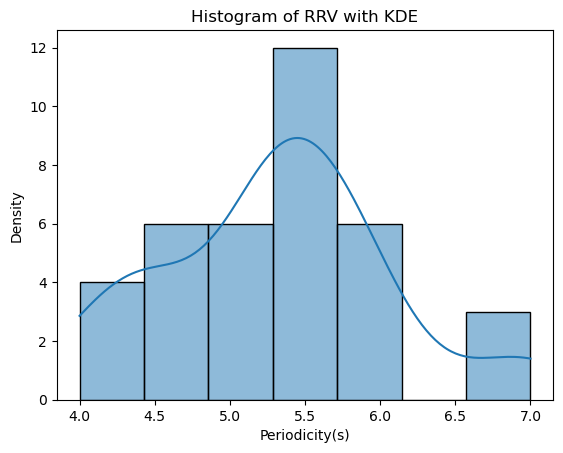

In [23]:
#hist_show(periods1)

#Or alternatively....

hist_KDE(periods1,"RRV")

In [24]:
##Second File

periods_b1=periodi(X_pca_Acc2_comp2_filtered,logFreq2)
periods_b2=periodi(X_pca_Acc2_comp1_filtered,logFreq2)
periods_b3=periodi(X_pca_Acc2_filtered,logFreq2)

periods_b4=periodi(X_pca_Gyro2_comp2_filtered,logFreq2)
periods_b5=periodi(X_pca_Gyro2_comp1_filtered,logFreq2)
periods_b6=periodi(X_pca_Gyro2_filtered,logFreq2)

periods_b7=periodi(acc2_filt,logFreq2)
periods_b8=periodi(gyro2_filt,logFreq2)

periods2=periods_b1+periods_b2+periods_b3+periods_b4+periods_b5+periods_b6+periods_b7+periods_b8

#periods2

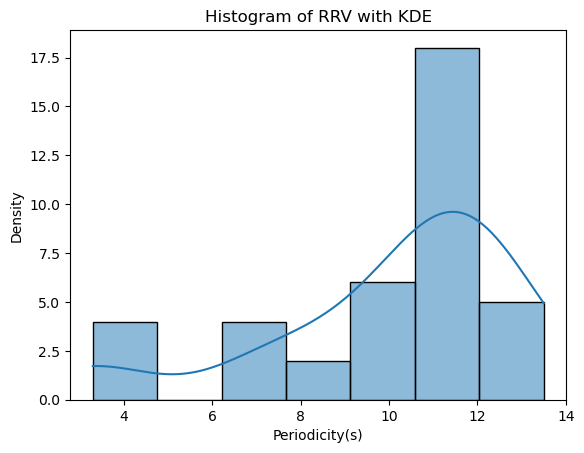

In [25]:
#hist_show(periods2)

#Or alternatively....

hist_KDE(periods2,"RRV")

As we stated at the beginning of our analysis, also in this case the data seems normally distriuibuted. 
The Histograms follow a Gaussian, centered in the point corrisponding to the mean value of RRV. 

From the histograms displayed, we can state that:
 - for the first patient (file 1), the mean value of RRV is 5.5 second circa, which means that the mean number of breaths for second is gonna be equal to 0.18, and for minutes 10,9 circa (which is indeed confirmed by the RPM)
 - while, for the second patient (file 2), the mean value of RRV is around 11 second, which means that the mean number of breaths for second is gonna be equal to 0.09, and for minutes 5,45 (confirmed by the RPM and the results obtained by the filtering). 

While, in the first case, the RRV and RPM is consistent with the general informations about respiratory rythms in healthy subjects, in the second case the number of breaths for minute is kinda lower than we would have expected. 
This could mean that, maybe, the patient is sleeping, and the data are recorded in a situation in which, naturally, the respiratory rate is lower. Or, maybe, the second patient is older than the first one, which could explain the slowdown of the breath rythm. 

5. **Optional**: Elaborate a simple algorithm to extrapolate the respiratory rate even when the filter fails (e.g. look for a particular threshold...).  

In [26]:
def extract_periodicity(signal):
    peaks, _ = find_peaks(signal, height=-1000)
    
    if len(peaks) < 2:
        raise ValueError("Non abbiamo periodicità")
        
    period = np.mean(np.diff(peaks))
    
    return period

def RR_extraction_all_files():
    
    v=[]
    
    for filename in os.listdir():
        if filename.endswith(".txt") and filename!="config_1.txt" and filename!="config_5.txt":
        # open the file and read its contents
            df3, logFreq3=load_txt(filename, 2000, 12000)
    
            X3=df3[["AccX","AccY","AccZ"]].values
            eigenvalues3, eigenvectors3, explained_variance_ratio3 = pca_eigenvalue_decomposition(X3)
            X_pca_Acc3 = np.dot(X3, eigenvectors3[:, :2])
    
            X3g=df3[["GyroX", "GyroY", "GyroZ"]].values
            eigenvalues3g, eigenvectors3g, explained_variance_ratio3g = pca_eigenvalue_decomposition(X3g)
            X_pca_Gyro3 = np.dot(X3g, eigenvectors3g[:, :2])
            
            v.append(extract_periodicity(X_pca_Gyro3.T[0]))
            v.append(extract_periodicity(X_pca_Gyro3.T[1]))
            v.append(extract_periodicity(X_pca_Acc3.T[0]))
            v.append(extract_periodicity(X_pca_Acc3.T[1]))
    
    return np.mean(v)

####################################
e_rr=[]

#Applico la funzione alle accelerazioni e velocità angolari Dei due DF
e_rr.append(extract_periodicity(X_pca_Gyro2.T[0]))
e_rr.append(extract_periodicity(X_pca_Gyro2.T[1]))
e_rr.append(extract_periodicity(X_pca_Gyro1.T[0]))
e_rr.append(extract_periodicity(X_pca_Gyro1.T[1]))
e_rr.append(extract_periodicity(X_pca_Acc2.T[0]))
e_rr.append(extract_periodicity(X_pca_Acc2.T[1]))
e_rr.append(extract_periodicity(X_pca_Acc1.T[0]))
e_rr.append(extract_periodicity(X_pca_Acc1.T[1]))

print(str(int(60/np.mean(e_rr)))+" Breathes on average.")

##################################

#Applico l'estrazione a tutti i File che ho a disposizione per avere una media piu accurata
print(str(int(60/RR_extraction_all_files()))+" Breathes on average, if I use all the files.")

17 Breathes on average.
18 Breathes on average, if I use all the files.


6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

What has been done in this work is basically taking the acceleration and angular velocity signals from two sensors applied to two different patients and processing them, with the ultimate goal of extracting the Respiratory Rate.
Step by step, what was done is:

-Acquiring the data, visualizing it, and extracting the principal components from the two signals using PCA and examining the obtained results.

-Extracting some statistical data and evaluating which can better describe our data.

-Applying FFT to the two signals, for each of the two analyzed files, and extracting, through appropriate filtering, a signal that can represent the respiratory rate.

Initially, the signals related to the two files used were deeply different, due to the body placements, noise, and, last but not least, a different patient (with their own pathologies and Respiratory and Cardiac rates).

In the mandatory file the signals looked very corrupted  and, in particular on acceleration, it’s impossible extract some meaningful informations. In the second file on both signals ( acceleration and angular velocity along the 3 axes) we can observe a clear periodicity of the signals with a lot of peaks that underline the heart rate of the patient.

We performed the same analysis on both files, finding out the principal components and the statistical values. After that we applied FFT on Acceleration and Angular velocity of the two files, in order to extract the frequency band on which the RR of the patient tipically works, according to their own diseases.

With the aim of doing that, we found out the peaks(in frequency) related to the different spectrum. Starting from these values, we selected the proper cutoff frequencies that can filter our corrupted and noisy signals, implementing a pass-band filter. We want to highlight that this part was one of the most critical issues that we encoutered during the implementation of this work, and overcome it with a reasonable solution was very challenging.

In particular, we used: \
-**Signals of file nr.1** : We selected 0.15 and 0.2 Hz as Cutoff frequencies. \
-**Signals of file nr.2** : We selected 0.07 and 0.15 Hz as Cutoff frequencies.


With the purpose to have a filtering that is more accurate and robust as possible, we decided to filter the 2 principal components(p.c.) of every signal, the sum of them and the the sum of FFT of the 2 p.c.

At this point, by observing the various signals from the two files, we could be quite sure that we had obtained filtered data that very clearly described the respiratory rate. On the two different files we can clearly observe the different periodicity, due to the fact that patients are not the same person and have different lifestyles, levels of training, and pathologies.

With a simple algorithm we analitically extracted the periods of our signals, computing the difference between the peaks and showing the histogram that represent the distribution of RRV and RPM. We tried to identify some relevant information between the histograms, and what we concluded is:

**Patient nr.1**: We have a Distribution of RRV that is similar to a Gaussian, centered in 5.5. So the patient probably have around 11 Breaths for minute, that is a normal value on average for a subject that is lying.\
**Patient nr.2**: We have an another Gaussian that is centered in 11. We supposed, by looking to the data, that the patient probably suffer of a pathology, according to the fact that an healthy subject has normally 10-20 breaths for minute.

This last part was very challenging, and overcome the fact that we had to interpret the data with no certainty of what we pointed out was not trivial at all.

##### References:
[1] Comparison between Chest-Worn Accelerometer and Gyroscope Performance for Heart Rate and Respiratory Rate Monitoring. Chiara Romano et al., Biosensors, 2022.